In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print

%load_ext rich


## Problem 1


In [3]:
sales = pd.read_csv("./sales.csv").iloc[:, 0].to_frame()

In [4]:
sales

,DAILY SALES
0,84
1,86
2,107
3,89
4,89
...,...
995,80
996,88
997,53
998,93


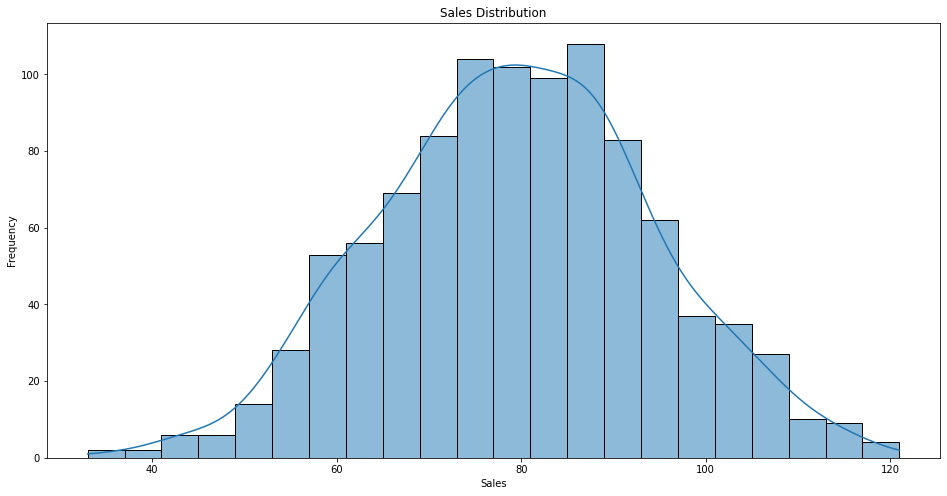

In [5]:
plt.figure(figsize=(16, 8))
ax = sns.histplot(data=sales, x="DAILY SALES", kde=True)
ax.set_title("Sales Distribution")
ax.set_xlabel("Sales")
ax.set_ylabel("Frequency")

plt.show()

The plot above shows that the `DAILY SALES` follows a normal distribution.


### PDF of a normal distribution

The probability density function of a normal distribution is given by

$$
f(x_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

The probability of observing a set of $N$ independent measurements $\{x_i\}$ is the product of the individual probabilities, given by

$$
P(x) = \prod_{i=1}^N f(x_i)
$$


### Log-likelihood

Taking the logarithm of the probability, we have

$$
\begin{align*}
L(\mu, \sigma^2) &= \log \left(\prod_{i=1}^N f(x_i)\right) \\
&= \sum_{i=1}^N \log f(x_i) \\
&= \sum_{i=1}^N \log \left(\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)\right) \\
&= \sum_{i=1}^N \left(\log \frac{1}{\sqrt{2\pi\sigma^2}} + \log \exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)\right) \\
&= \sum_{i=1}^N \left(\log 1 - \log \sqrt{2\pi\sigma^2} - \frac{(x_i-\mu)^2}{2\sigma^2}\right) \\
L(\mu, \sigma^2) &= -\frac{N}{2}\log 2\pi\sigma^2 - \frac{1}{2\sigma^2}\sum_{i=1}^N (x_i-\mu)^2

\end{align*}
$$

The log-likelihood is maximized when the derivative with respect to $\mu$ and $\sigma^2$ are zero. Alternatively, the same result can be obtained by minimizing the negative log-likelihood

$$
\begin{align*}
-L(\mu, \sigma^2) = \frac{N}{2}\log 2\pi\sigma^2 + \frac{1}{2\sigma^2}\sum_{i=1}^N (x_i-\mu)^2
\end{align*}
$$


### Maximum likelihood optimization

The maximum likelihood estimates of $\mu$ and $\sigma^2$ are given by

$$
\begin{align*}
\max_{\mu, \sigma^2} L(\mu, \sigma^2) &= \min_{\mu, \sigma^2} -L(\mu, \sigma^2) \\
&= \min_{\mu, \sigma^2} \frac{N}{2}\log 2\pi\sigma^2 + \frac{1}{2\sigma^2}\sum_{i=1}^N (x_i-\mu)^2
\end{align*}
$$


In [6]:
def negative_log_likelihood(mu, sigma, x):
    """
    Calculate the negative log-likelihood

    Parameters:
    mu (float): The mean of the distribution.
    sigma (float): The standard deviation of the distribution.
    x (array_like): The observed data points.
    N (int): The number of observations in x.

    Returns:
    float: The negative log-likelihood of the data x given the parameters mu and sigma.
    """
    N = len(x)

    return (N / 2) * np.log(2 * np.pi * sigma**2) + (1 / (2 * sigma**2)) * np.sum(
        (x - mu) ** 2, axis=0
    )

In [7]:
print(
    f"Negative log-likelihood with mean = 0 and SD = 1: {negative_log_likelihood(0, 1, sales.iloc[:, 0])}"
)
print(
    f"Negative log-likelihood with mean = 10 and SD = 5: {negative_log_likelihood(10, 5, sales.iloc[:, 0])}"
)

Negative log-likelihood with mean = 0 and SD = 1: 3260658.4385332046

Negative log-likelihood with mean = 10 and SD = 5: 103166.35644563877

### Gradient descent

Now that we have the negative log-likelihood function in place, we can use gradient descent to find the optimal parameters $\mu$ and $\sigma^2$ that minimize the negative log-likelihood function.

The gradients are given by

$$
\begin{align*}
\frac{\partial L}{\partial \mu} &= -\frac{1}{\sigma^2}\sum_{i=1}^N (x_i-\mu) \\
\frac{\partial L}{\partial \sigma} &= \frac{N}{\sigma} - \frac{1}{\sigma^3}\sum_{i=1}^N (x_i-\mu)^2
\end{align*}
$$,

where $L$ is the negative log-likelihood function.
$$


In [8]:
def gradient_descent(mu_init, sigma_init, x, learning_rate, epochs, debug=False):
    """
    Perform gradient descent to minimize the negative log likelihood for mu and sigma.

    Parameters:
    mu_init (float): The initial value of mu.
    sigma_init (float): The initial value of sigma.
    x (array_like): The observed data points.
    learning_rate (float): The learning rate.
    epochs (int): The number of iterations to perform gradient descent.

    Returns:
    tuple: The learned values of mu and sigma that minimize the negative log likelihood.
    """
    N = len(x)
    mu = mu_init
    sigma = sigma_init

    for i in range(epochs):
        mu_gradient = -(1 / sigma**2) * np.sum(x - mu, axis=0)
        sigma_gradient = (N / sigma) - (1 / sigma**3) * np.sum((x - mu) ** 2, axis=0)

        mu = mu - learning_rate * mu_gradient
        sigma = sigma - learning_rate * sigma_gradient

        if debug and i % 1000 == 0:
            print(f"Epoch {i} | mu: {mu} | sigma: {sigma}")

    return mu, sigma

In [9]:
epochs = 10000
learning_rate = 0.001

mu_optimal, sigma_optimal = gradient_descent(
    0, 10, sales.iloc[:, 0], learning_rate, epochs, debug=False
)

print(
    f"Optimal parameters after {epochs} epochs with learning rate {learning_rate}: mu = {mu_optimal:4f}, sigma = {sigma_optimal:.4f}"
)

Optimal parameters after 10000 epochs with learning rate 0.001: mu = 79.379000, sigma = 14.7802

In [11]:
print(
    f"Negative log-likelihood with mean = {mu_optimal:.4f} and SD = {sigma_optimal:.4f}: {negative_log_likelihood(mu_optimal, sigma_optimal, sales.iloc[:, 0])}"
)


Negative log-likelihood with mean = 79.3790 and SD = 14.7802: 4112.224799102469

In [12]:
print(
    f"True parameters: mu = {sales['DAILY SALES'].mean():.4f}, sigma = {sales['DAILY SALES'].std():.4f}"
)


True parameters: mu = 79.3790, sigma = 14.7876

### Comparing the results

| Parameter | True Value | Estimated Value |
| --------- | ---------- | --------------- |
| $\mu$     | 79.3790    | 79.3790         |
| $\sigma$  | 14.7876    | 14.7802         |


## Problem 2


In [13]:
def f(x, y):
    return (x - 5) ** 2 + 2 * (y + 3) ** 2 + x * y

In [14]:
def g(x, y):
    return (1 - (y - 3)) ** 2 + 10 * ((x + 4) - (y - 3) ** 2) ** 2


### Calculating the derivatives


#### `f(x,y)`

$f(x, y) = (x - 5)^2 + 2(y + 3)^2 + xy$

$$
\begin{align*}
\frac{\partial f}{\partial x} &= 2(x - 5) + y \\
\frac{\partial f}{\partial y} &= 4(y + 3) + x \\
\end{align*}
$$


In [15]:
def f_x_gradient(x, y):
    return 2 * (x - 5) + y


def f_y_gradient(x, y):
    return 4 * (y + 3) + x


#### `g(x,y)`

$g(x, y) = (1 - (y - 3)) ^ 2 + 10 ((x + 4) - (y - 3) ^ 2)^ 2$

$$
\begin{align*}
\frac{\partial g}{\partial x} &= 20(x + 4 - (y - 3)^2) \\
\frac{\partial g}{\partial y} &= - 2(4 - y) + 20(x+4 - (y-3)^2) * -2(y-3) \\
\end{align*}
$$


In [16]:
def g_x_gradient(x, y):
    return 20 * (x + 4 - (y - 3) ** 2)


def g_y_gradient(x, y):
    return -2 * (4 - y) + 20 * (x + 4 - (y - 3) ** 2) * -2 * (y - 3)

In [17]:
def optimize_function(
    x_init,
    y_init,
    learning_rate,
    epochs,
    func,
    x_gradient_func,
    y_gradient_func,
    debug=False,
    decay_rate=1,
    exponential_decay=False,
    inverse_decay=False,
    tolerance=1e-8,
):
    """
    Perform gradient descent to minimize the function.

    Parameters:
    x_init (float): The initial value of x.
    y_init (float): The initial value of y.
    learning_rate (float): The learning rate.
    epochs (int): The number of iterations to perform gradient descent.
    func (callable): The function to minimize.
    x_gradient_func (callable): The function to compute the gradient with respect to x.
    y_gradient_func (callable): The function to compute the gradient with respect to y.
    debug (bool): Whether to print the current values of x, y, and the function every 10 epochs.
    decay_rate (float): The decay rate for the learning rate.
    exponential_decay (bool): Whether to use exponential decay.
    inverse_decay (bool): Whether to use inverse decay.
    tolerance (float): The tolerance for the stopping condition.

    Returns:
    tuple: The learned values of x and y, and the function values at each step.
    """
    x = x_init
    y = y_init
    prev_step = func(x, y)

    steps = [prev_step]

    for i in range(epochs):
        x_gradient = x_gradient_func(x, y)
        y_gradient = y_gradient_func(x, y)

        if exponential_decay and inverse_decay:
            raise ValueError("Only one decay rate can be used at a time.")

        if exponential_decay:
            learning_rate = learning_rate * np.exp(-decay_rate * i)
        elif inverse_decay:
            learning_rate = learning_rate / (1 + decay_rate * i)
        x = x - learning_rate * x_gradient
        y = y - learning_rate * y_gradient

        current_step = func(x, y)
        steps.append(current_step)

        if debug and i % 10 == 0:
            print(f"Epoch {i} | x: {x} | y: {y} | func(x, y): {func(x, y)}")

        if np.abs(current_step - prev_step) < tolerance:
            print(
                f"Converged at epoch {i} with function {func.__name__} value {current_step}\n"
            )
            return {"x": x, "y": y, "steps": steps}

        prev_step = current_step

    print(
        f"Converged at epoch {i} with function {func.__name__} value {current_step}\n"
    )
    return {"x": x, "y": y, "steps": steps}

In [19]:
def run_optimization(
    func,
    x_grad,
    y_grad,
    learning_rate,
    decay_rate,
    epochs,
    debug=False,
    exponential=False,
    inverse=False,
    tolerance=1e-8,
):
    print(
        f'Optimizing function "{func.__name__}" with parameters:\n{learning_rate=}, {epochs=}, {decay_rate=}, {exponential=}, {inverse=}, {tolerance=}\n'
    )
    return optimize_function(
        x_init=0,
        y_init=2,
        learning_rate=learning_rate,
        epochs=epochs,
        func=func,
        x_gradient_func=x_grad,
        y_gradient_func=y_grad,
        debug=debug,
        decay_rate=decay_rate,
        exponential_decay=exponential,
        inverse_decay=inverse,
        tolerance=tolerance,
    )

### Compare learning rates


In [31]:
f_lr = 0.15
g_lr = 0.0015

decay_rate = 0.05
epochs = 100
tolerance = 1e-8


In [32]:
optimization_results = {}

# Define a dictionary to map the optimization types to their respective parameters
optimization_types = {
    "constant": {"exponential": False, "inverse": False},
    "exponential": {"exponential": True, "inverse": False},
    "inverse": {"exponential": False, "inverse": True},
}

# Run optimization for function f with different decay strategies
for opt_type, params in optimization_types.items():
    optimization_results[f"f_{opt_type}"] = run_optimization(
        f,
        f_x_gradient,
        f_y_gradient,
        f_lr,
        decay_rate,
        epochs,
        **params,
        tolerance=tolerance,
    )

# Run optimization for function g with different decay strategies
for opt_type, params in optimization_types.items():
    optimization_results[f"g_{opt_type}"] = run_optimization(
        g,
        g_x_gradient,
        g_y_gradient,
        g_lr,
        decay_rate,
        epochs,
        **params,
        tolerance=tolerance,
    )


Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.05, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 41 with function f value -23.285714276923436

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.05, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 28 with function f value -19.53253046416537

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.05, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 33 with function f value -20.100598255344362

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.05, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 99 with function g value 8.098991392728818

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.05, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 28 with function g value 11.24412009036023

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.05, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 33 with function g value 10.541393488322607

The results are shown in the table below:

Function | Type of Learning Rate | Final Value | Number of Iterations | Decay Rate | Initial Learning Rate
--- | --- | --- | --- | --- | ---
$f(x, y)$ | Constant | -23.285 | 41 | - | 0.15
$f(x, y)$ | Exponential | -19.532 | 28 | 0.05 | 0.15
$f(x, y)$ | Inverse | -20.101 | 33 | 0.05 | 0.15
$g(x, y)$ | Constant | 8.099 | 99 | - | 0.0015
$g(x, y)$ | Exponential | 11.244 | 28 | 0.05 | 0.0015
$g(x, y)$ | Inverse | 10.541 | 33 | 0.05 | 0.0015

For function $f(x, y)$, the constant learning rate took the longest to converge, while the exponential learning rate took the least number of iterations to converge. The inverse learning rate took more iterations than the exponential learning rate, but less than the constant learning rate. 

For function $g(x, y)$, both decaying learning rate strategies significantly reduced the number of iterations required to converge, compared to the constant learning rate.

This suggests that employing a decaying learning rate can significantly reduce the number of iterations required to converge, compared to a constant learning rate. However, there is a trade-off between the speed of convergence and the accuracy of optimization, as the decaying learning rate may converge to a suboptimal solution, depending on the decay rate and the initial learning rate.

### Changing the decay rate

In [33]:
# Decay rate = 0.2
for opt_type, params in optimization_types.items():
    run_optimization(
        f,
        f_x_gradient,
        f_y_gradient,
        f_lr,
        0.2,
        epochs,
        **params,
        tolerance=tolerance,
    )

for opt_type, params in optimization_types.items():
    run_optimization(
        g,
        g_x_gradient,
        g_y_gradient,
        g_lr,
        0.2,
        epochs,
        **params,
        tolerance=tolerance,
    )


Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.2, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 41 with function f value -23.285714276923436

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.2, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 14 with function f value -7.291534492786422

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.2, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 20 with function f value -9.690795620190643

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.2, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 99 with function g value 8.098991392728818

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.2, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 15 with function g value 31.994600884607515

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.2, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 20 with function g value 27.780934588007486

In [34]:
# Decay rate = 0.01
for opt_type, params in optimization_types.items():
    run_optimization(
        f,
        f_x_gradient,
        f_y_gradient,
        f_lr,
        0.01,
        epochs,
        **params,
        tolerance=tolerance,
    )

for opt_type, params in optimization_types.items():
    run_optimization(
        g,
        g_x_gradient,
        g_y_gradient,
        g_lr,
        0.01,
        epochs,
        **params,
        tolerance=tolerance,
    )


Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.01, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 41 with function f value -23.285714276923436

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.01, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 55 with function f value -23.183649212668833

Optimizing function "f" with parameters:
learning_rate=0.15, epochs=100, decay_rate=0.01, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 60 with function f value -23.19932161406965

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.01, exponential=False, inverse=False, tolerance=1e-08

Converged at epoch 99 with function g value 8.098991392728818

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.01, exponential=True, inverse=False, tolerance=1e-08

Converged at epoch 51 with function g value 8.391031272943126

Optimizing function "g" with parameters:
learning_rate=0.0015, epochs=100, decay_rate=0.01, exponential=False, inverse=True, tolerance=1e-08

Converged at epoch 55 with function g value 8.389289888097275

By increasing the decay rate to 0.2, both the functions converge faster (both exponential and inverse learning rates) compared to the decay rate of 0.05. However, the final value of the objective function is higher than the decay rate of 0.05. This suggests that a higher decay rate may lead to faster convergence, but may also lead to a suboptimal solution. 

Conversely, a lower decay rate of 0.01 leads to slower convergence, but a lower final value of the objective function. This suggests that a lower decay rate may lead to slower convergence, but may also lead to a more optimal solution.

Therefore, exploring different decay rates is important to find the optimal decay rate that balances the speed of convergence and the accuracy of optimization.

### Plotting cost function

Finally, we can plot the cost functions against the number of iterations for each of the learning rate strategies. The plots will show the convergence behavior of the optimization algorithm for each learning rate strategy, and provide insights into the trade-offs between the speed of convergence and the accuracy of optimization.

#### Constant learning rate


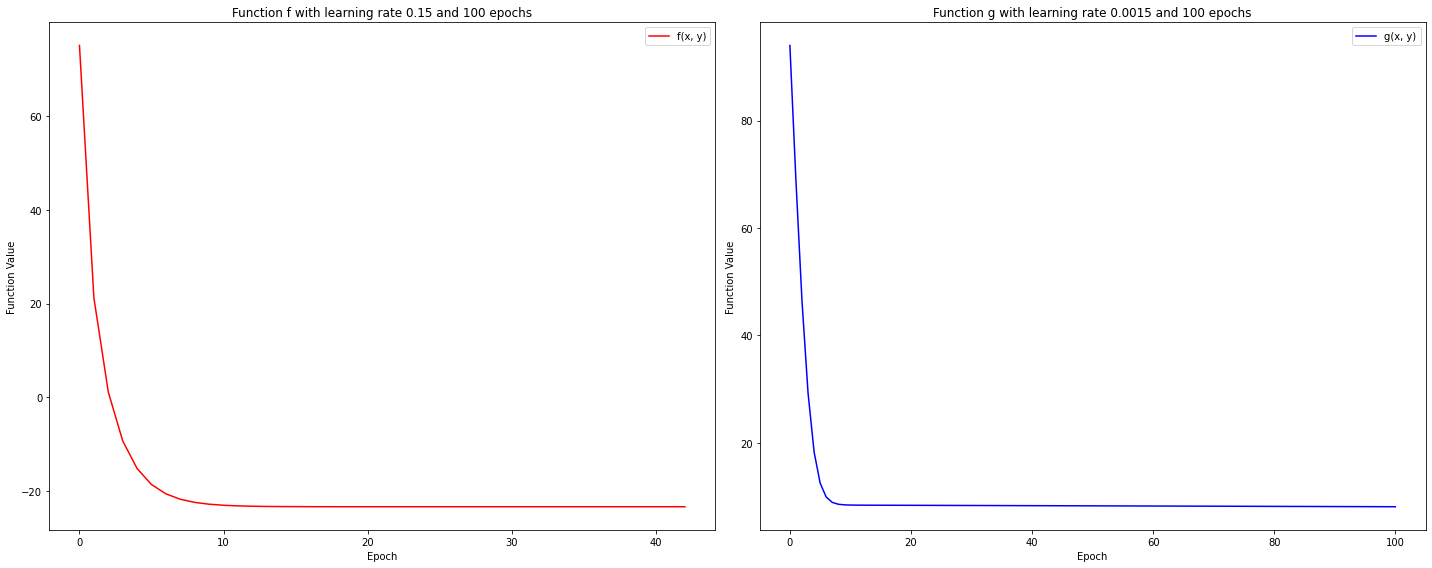

In [35]:
# Plot f and g for constant learning rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    data=optimization_results["f_constant"]["steps"],
    label="f(x, y)",
    ax=ax1,
    color="red",
)
ax1.set_title(f"Function f with learning rate {f_lr} and {epochs} epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Function Value")
ax1.legend()

sns.lineplot(
    data=optimization_results["g_constant"]["steps"],
    label="g(x, y)",
    ax=ax2,
    color="blue",
)
ax2.set_title(f"Function g with learning rate {g_lr} and {epochs} epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Function Value")
ax2.legend()

plt.tight_layout()
plt.show()

#### Constant vs. exponential


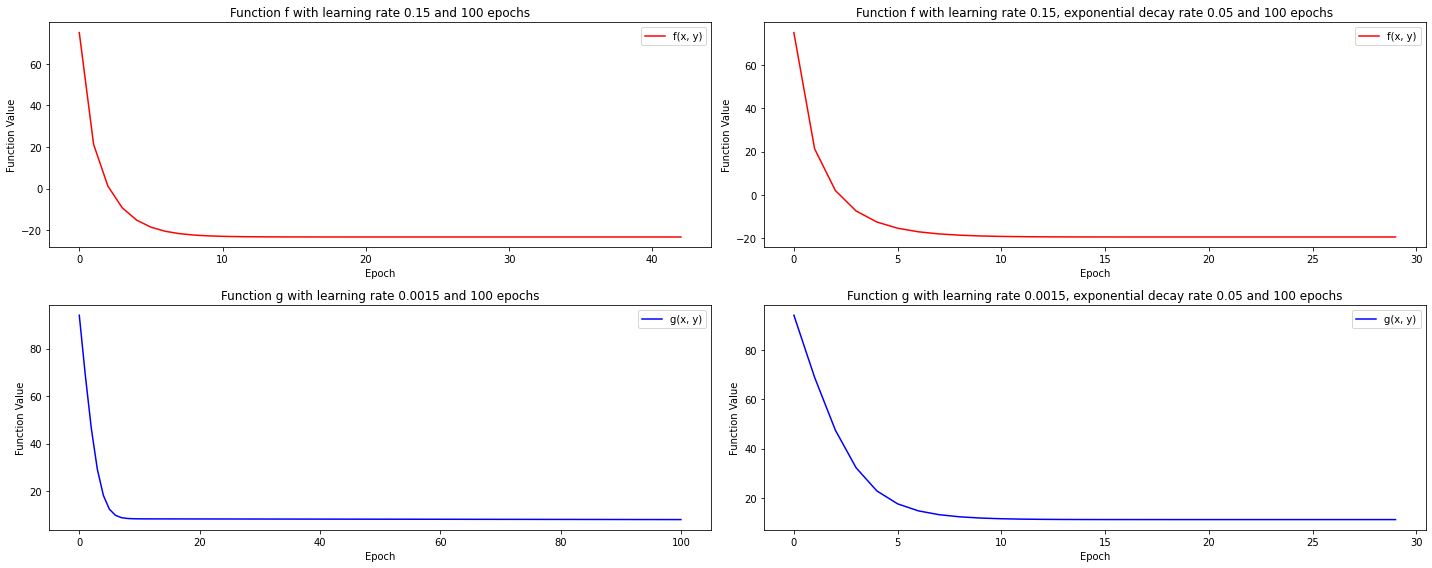

In [36]:
# Plot f and g for constant vs exponential decay
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 8))

sns.lineplot(
    data=optimization_results["f_constant"]["steps"],
    label="f(x, y)",
    ax=ax1[0],
    color="red",
)
ax1[0].set_title(f"Function f with learning rate {f_lr} and {epochs} epochs")
ax1[0].set_xlabel("Epoch")
ax1[0].set_ylabel("Function Value")
ax1[0].legend()

sns.lineplot(
    data=optimization_results["f_exponential"]["steps"],
    label="f(x, y)",
    ax=ax1[1],
    color="red",
)
ax1[1].set_title(
    f"Function f with learning rate {f_lr}, exponential decay rate {decay_rate} and {epochs} epochs"
)
ax1[1].set_xlabel("Epoch")
ax1[1].set_ylabel("Function Value")
ax1[1].legend()

# ---

sns.lineplot(
    data=optimization_results["g_constant"]["steps"],
    label="g(x, y)",
    ax=ax2[0],
    color="blue",
)

ax2[0].set_title(f"Function g with learning rate {g_lr} and {epochs} epochs")
ax2[0].set_xlabel("Epoch")
ax2[0].set_ylabel("Function Value")
ax2[0].legend()

sns.lineplot(
    data=optimization_results["g_exponential"]["steps"],
    label="g(x, y)",
    ax=ax2[1],
    color="blue",
)

ax2[1].set_title(
    f"Function g with learning rate {g_lr}, exponential decay rate {decay_rate} and {epochs} epochs"
)
ax2[1].set_xlabel("Epoch")
ax2[1].set_ylabel("Function Value")
ax2[1].legend()

plt.tight_layout()
plt.show()

#### Constant vs. inverse


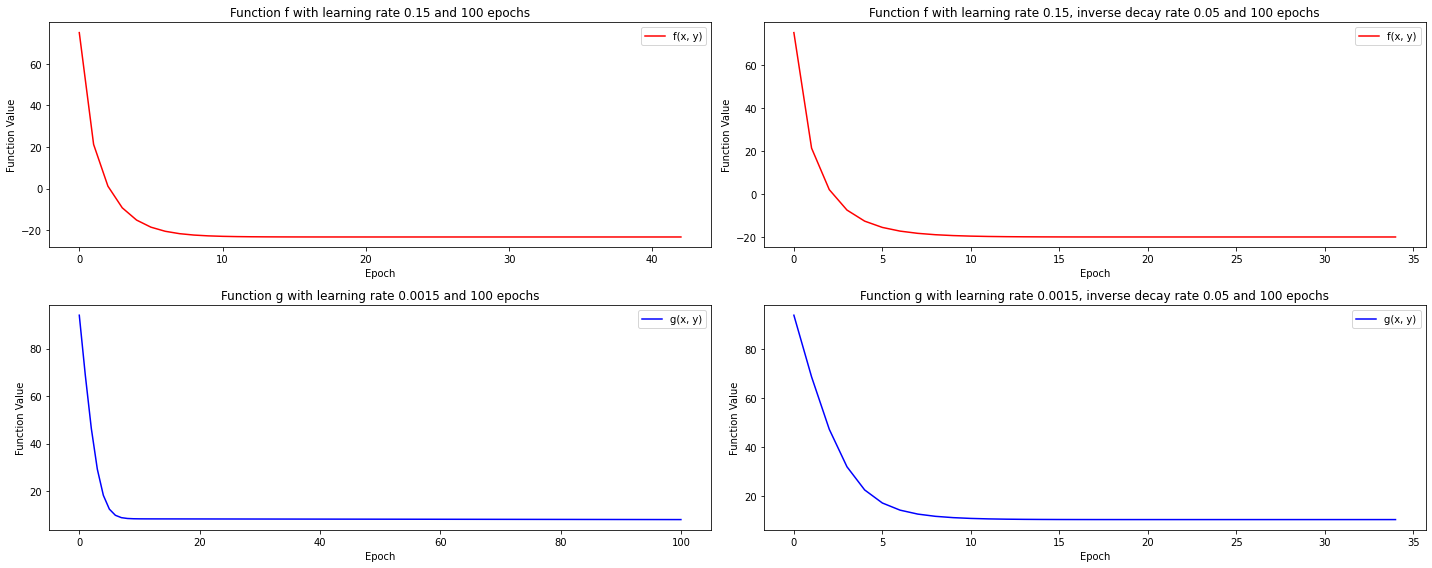

In [37]:
# Plot f and g for constant vs exponential decay
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 8))

sns.lineplot(
    data=optimization_results["f_constant"]["steps"],
    label="f(x, y)",
    ax=ax1[0],
    color="red",
)
ax1[0].set_title(f"Function f with learning rate {f_lr} and {epochs} epochs")
ax1[0].set_xlabel("Epoch")
ax1[0].set_ylabel("Function Value")
ax1[0].legend()

sns.lineplot(
    data=optimization_results["f_inverse"]["steps"],
    label="f(x, y)",
    ax=ax1[1],
    color="red",
)
ax1[1].set_title(
    f"Function f with learning rate {f_lr}, inverse decay rate {decay_rate} and {epochs} epochs"
)
ax1[1].set_xlabel("Epoch")
ax1[1].set_ylabel("Function Value")
ax1[1].legend()

# ---

sns.lineplot(
    data=optimization_results["g_constant"]["steps"],
    label="g(x, y)",
    ax=ax2[0],
    color="blue",
)

ax2[0].set_title(f"Function g with learning rate {g_lr} and {epochs} epochs")
ax2[0].set_xlabel("Epoch")
ax2[0].set_ylabel("Function Value")
ax2[0].legend()

sns.lineplot(
    data=optimization_results["g_inverse"]["steps"],
    label="g(x, y)",
    ax=ax2[1],
    color="blue",
)

ax2[1].set_title(
    f"Function g with learning rate {g_lr}, inverse decay rate {decay_rate} and {epochs} epochs"
)
ax2[1].set_xlabel("Epoch")
ax2[1].set_ylabel("Function Value")
ax2[1].legend()

plt.tight_layout()
plt.show()